In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [28]:
## Environment
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/models'):
    main_path = p[:-len('/models')]
sys.path[0] = main_path

import os, gc
from termcolor import colored
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from src import (config, fe, features, model_selection,preprocess, training)
from src.fe import CreateFeatures

In [3]:
# DATA PREPARATION
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Define SAM testbed files
sam_files = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['features_path']
sam_files = sam_files.to_dict()

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

# SAM testbed labels
sam_labels = train_labels.drop(train_labels.tail(len(sam_files)).index)
sam_labels = pd.concat([sam_labels, valid_labels], axis=0)
print(f'Labels w/o SAM : {sam_labels.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)
['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']
Labels w/o SAM : (1047, 11)


In [7]:
FTS_NAME = 'fts_mra_tempmz'                 # Name of the file with features
COMPUTE_FTS = False                         # Should the features be recomputed
COMPUTE_FTS_SAM = False                      # Compute SAM test bed
MODEL_ALGO = 'XGB_opt'                      # Name of the classifier
MODEL_NAME = FTS_NAME + '_' + MODEL_ALGO    # Name of the model

**COMPUTE FEATURES**

- Change the `fe._` method depending on the feature that we wish to calculate

In [6]:
# Check if feature is computed and load it or choose to compute it
check_file = 0
for i in ['_tr', '_trvl', '_vlte']:
    check_file += os.path.exists(os.path.join(config.DATA_DIR_OUT, FTS_NAME +
                                              str(i) + '.csv'))

if (check_file == 3) & (not COMPUTE_FTS):
    print('Reading features ... ')
    X_tr = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_tr.csv'))
    print(X_tr.shape)
    X_trvl = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_trvl.csv'))
    print(X_trvl.shape)
    X_vlte = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_vlte.csv'))
    print(X_vlte.shape)
    
else:
    print('Computing features ... ')
    # ----- TRAIN -----
    fe = CreateFeatures(metadata, train_files, 'tr', FTS_NAME)
    X_tr = fe.fts_mra_tempmz()
    print(colored(f'train => {X_tr.shape}', 'blue'))
    
    # ----- TRAIN & VALID -----
    fe = CreateFeatures(metadata, trva_files, 'trvl', FTS_NAME)
    X_trvl = fe.fts_mra_tempmz()
    print(colored(f'train => {X_trvl.shape}', 'blue'))
    
    # ----- VALID & TEST -----
    fe = CreateFeatures(metadata, all_test_files, 'vlte', FTS_NAME)
    X_vlte = fe.fts_mra_tempmz()
    print(colored(f'train => {X_vlte.shape}', 'blue'))
    
if COMPUTE_FTS_SAM:
    print(f'\nCreating SAM testbed samples ...')
    # Training without SAM testbed
    X_tr_sam = X_tr.drop(X_tr.tail(len(sam_files)).index).copy()
    X_tr_sam = pd.concat([X_tr_sam, X_trvl.iloc[len(train_files):,:]], axis=0)
    print(f'Train shape: {X_tr_sam.shape}')
    # Validation data
    X_vl_sam = X_tr.tail(len(sam_files)).copy()
    print(f'Valid shape: {X_vl_sam.shape}')

Reading features ... 
(766, 1584)
(1059, 1584)
(804, 1584)


In [58]:
# Read in full model trained on TR
sfm_loss = {}
for label in target_labels_list:
    MODEL_CLF = 'fts_mra_tempmz_XGB_opt_tr_' + label + '.joblib.dat'
    VT_SAMPLE = FTS_NAME + '_vlte.csv'
    # Load saved model
    clf = joblib.load(os.path.join(config.MODELS_DIR, MODEL_CLF))
    selection = SelectFromModel(clf, threshold=0.002, prefit=True)
    X_tr_sfm = selection.transform(X_tr)
    print(X_tr_sfm.shape)
    # train model
    clf_sfm = xgb.XGBClassifier(objective = "binary:logistic",
                                use_label_encoder = False,
                                eval_metric = 'logloss',
                                learning_rate = 0.09)
    clf_sfm.fit(X_tr_sfm, train_labels[label])
    
    # Evaluate model
    select_X_test = selection.transform(X_vlte.iloc[:len(valid_files),:])
    y_pred = clf_sfm.predict_proba(select_X_test)[:,1]
    
    sfm_loss[label] = log_loss(valid_labels[label], y_pred, labels=(0,1))

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 146)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 126)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 150)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 159)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 25)
(766, 136)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 139)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 167)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 145)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(766, 93)


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [59]:
np.mean(list(sfm_loss.values()))

0.16057462445446352

In [123]:
df_mic = pd.DataFrame()
for label in target_labels_list:
    mic = mutual_info_classif(X_tr, train_labels[label])
    t = pd.DataFrame()
    t = pd.concat([t, pd.Series(X_tr.columns), pd.Series(mic)], axis=1, ignore_index=True)
    t.columns = ['feature', 'mic']
    t = t.sort_values(by='mic', ascending=False).reset_index(drop=True)
    t['target'] = label
    #t = t.iloc[:no_fts,:].copy()
    df_mic = pd.concat([df_mic, t], axis=0)
    # plt.subplots(1, figsize=(26, 1))
    # sns.scatterplot(x='mic', y='feature', color='blue', annot=True)
    # #plt.suptitle(label, fontsize=18, y=1.2)
    # #plt.gcf().subplots_adjust(wspace=0.2)
    # plt.show()

In [124]:
df_mic

,feature,mic,target
0,Ion_50.0_600_700,0.065969,basalt
1,Ion_44.0_200_300,0.065905,basalt
2,Ion_44.0_100_200,0.064635,basalt
3,Ion_15.0_500_600,0.063857,basalt
4,Ion_17.0_300_400,0.059130,basalt
...,...,...,...
1579,Ion_76.0_1100_1200,0.000000,sulfide
1580,Ion_41.0_0_100,0.000000,sulfide
1581,Ion_41.0_200_300,0.000000,sulfide
1582,Ion_41.0_400_500,0.000000,sulfide


In [125]:
t = df_mic[df_mic.mic > 0.002].copy()
t.shape

(12611, 3)

,feature,mic
0,Ion_50.0_600_700,0.066352
1,Ion_44.0_200_300,0.065905
2,Ion_44.0_100_200,0.064635
3,Ion_17.0_300_400,0.059130
4,Ion_32.0_300_400,0.058906


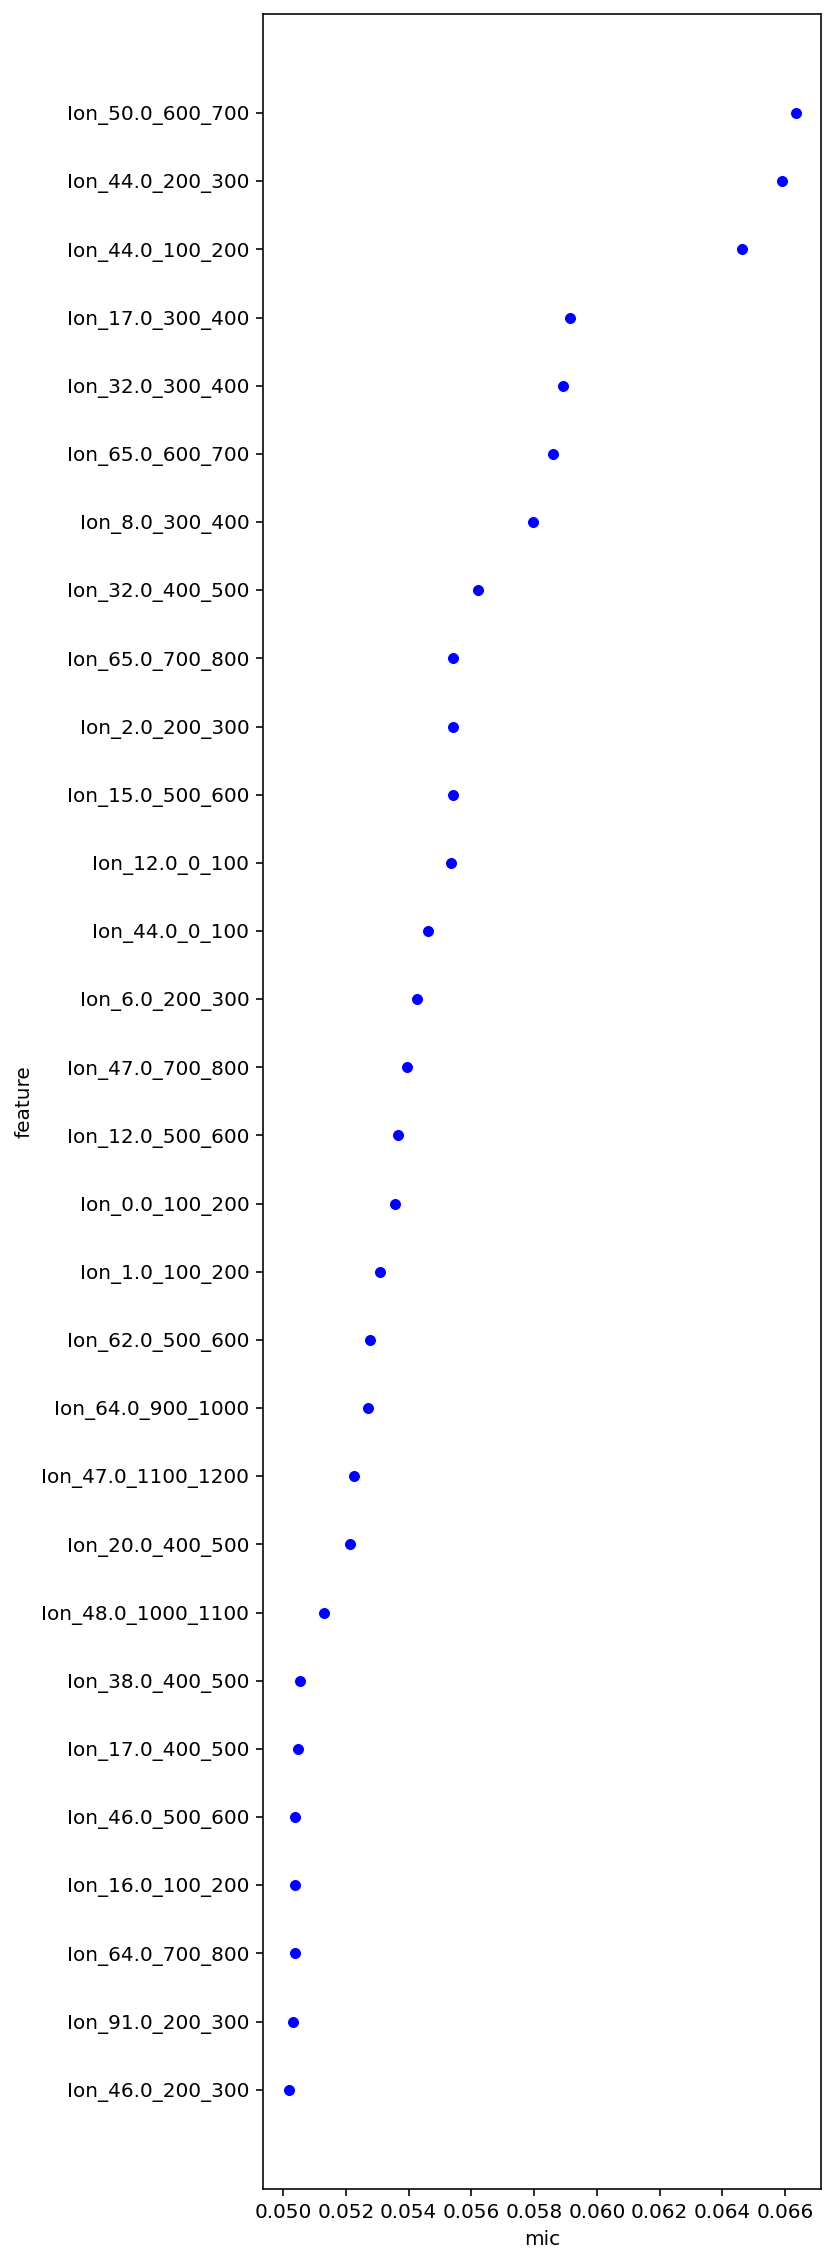

In [122]:
plt.subplots(1, figsize=(5, 15))
sns.scatterplot(x='mic', y='feature', color='blue', data=t)
#plt.suptitle(label, fontsize=18, y=1.2)
#plt.gcf().subplots_adjust(wspace=0.2)
plt.show()

## MODELS

**TRAIN**

In [ ]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_tr'
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               valid_files, valid_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_tr')

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)

**TRAIN & VALID**

In [ ]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_trvl,
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_trvl'
    )

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'CV logLoss Label')
print(cvloss)

**SAM TRAINING**

In [ ]:
# ===== TRAIN SAM =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr_sam,
    df_labels=sam_labels,
    target_list=target_labels_list,
    df_test=X_vl_sam,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_sam',
    test_sam=True
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               sam_files, sam_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_sam')

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)